# Project 4: Fuel Monitoring System Design
>**Date Created**: 21 February 2024<br>
>**Course**: AEM566 - Optimal Estimation<br>
>**Author**: Benjamin Lucke<br>

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import sympy as smp
from scipy.linalg import expm, solve_discrete_are

plt.rcParams["text.usetex"] = True
plt.rcParams["legend.edgecolor"] = "black"

In [38]:
# Read in data and label columns
data = r"fuel_data.csv"
df = pd.read_csv(data, header=None)
columnMapper = dict(
    zip(
        df.columns.values,
        ["t", "u_k", "y_k", "f_k", "b_k"],
    )
)
df = df.rename(columns=columnMapper)
df = df.fillna(100e22)
display(df.head())
z = df[["u_k", "y_k"]].to_numpy()

t        u_k           y_k          f_k       b_k
0  0.0   8.712638  1.000000e+24  3200.000000  0.050000
1  0.5  13.283346  2.245003e+01  3195.676728  0.099930
2  1.0   3.195561  2.164369e+01  3189.054264  0.005879
3  1.5   8.187671  1.981869e+01  3187.447473 -0.038837
4  2.0  13.939558  1.971915e+01  3183.364968  0.013155

In [39]:
Aline = 1  # cm**2
dt = 0.5  # sec
Atank = 150  # cm**2
Q = np.diag([Aline**2 * dt**2 * 0.1**2, 0.1**2])
R = 1**2
x0 = np.array([3000, 0])
P0 = np.diag([10**2, 0.1**2])

F = np.array([[1, Aline * dt], [0, 1]])
G = np.array([-Aline * dt, 0])
H = np.array([1 / Atank, 0])

## Part B - Discrete Kalman Filter

In [40]:
def predict(u, x, P, F, G, Q):
    xhat_k_km1 = np.dot(F, x) + np.dot(G, u)
    Phat_k_km1 = F @ P @ F.T + Q
    return xhat_k_km1, Phat_k_km1


def update(z, x, P, H, R):
    x_in = x
    z_in = z
    P_in = P

    yhat = z_in - np.dot(H, x_in)
    S = np.dot(np.dot(H, P_in), H.T) + R
    K = np.dot(np.dot(P_in, H.T), 1 / S)
    x_out = x_in + np.dot(K, yhat)
    P_out = P_in - np.dot(np.dot(K, H), P_in)
    return x_out, P_out, K

In [41]:
n = len(df.index)
res = np.zeros((n, 2))  # array to hold posterior state estimates
covs = np.zeros((2, 2, n))  # array to hold posterior P_k estimates
Ks = np.zeros((n, 2))  # array to hold Kalman gains
t = np.linspace(0, 300, n)  # array to plot data for
for k in range(n):
    if k == 0:
        x = x0
        P = P0
        res[k] = x
        covs[:, :, k] = P
        continue
    u = df.loc[k - 1, "u_k"]
    z = df[["u_k", "y_k"]].to_numpy()[k][1]
    xp, Pp = predict(u, x, P, F, G, Q)
    xu, Pu, K = update(z, xp, Pp, H, R)
    x = xu
    P = Pu
    res[k] = x
    covs[:, :, k] = P
    Ks[k] = K

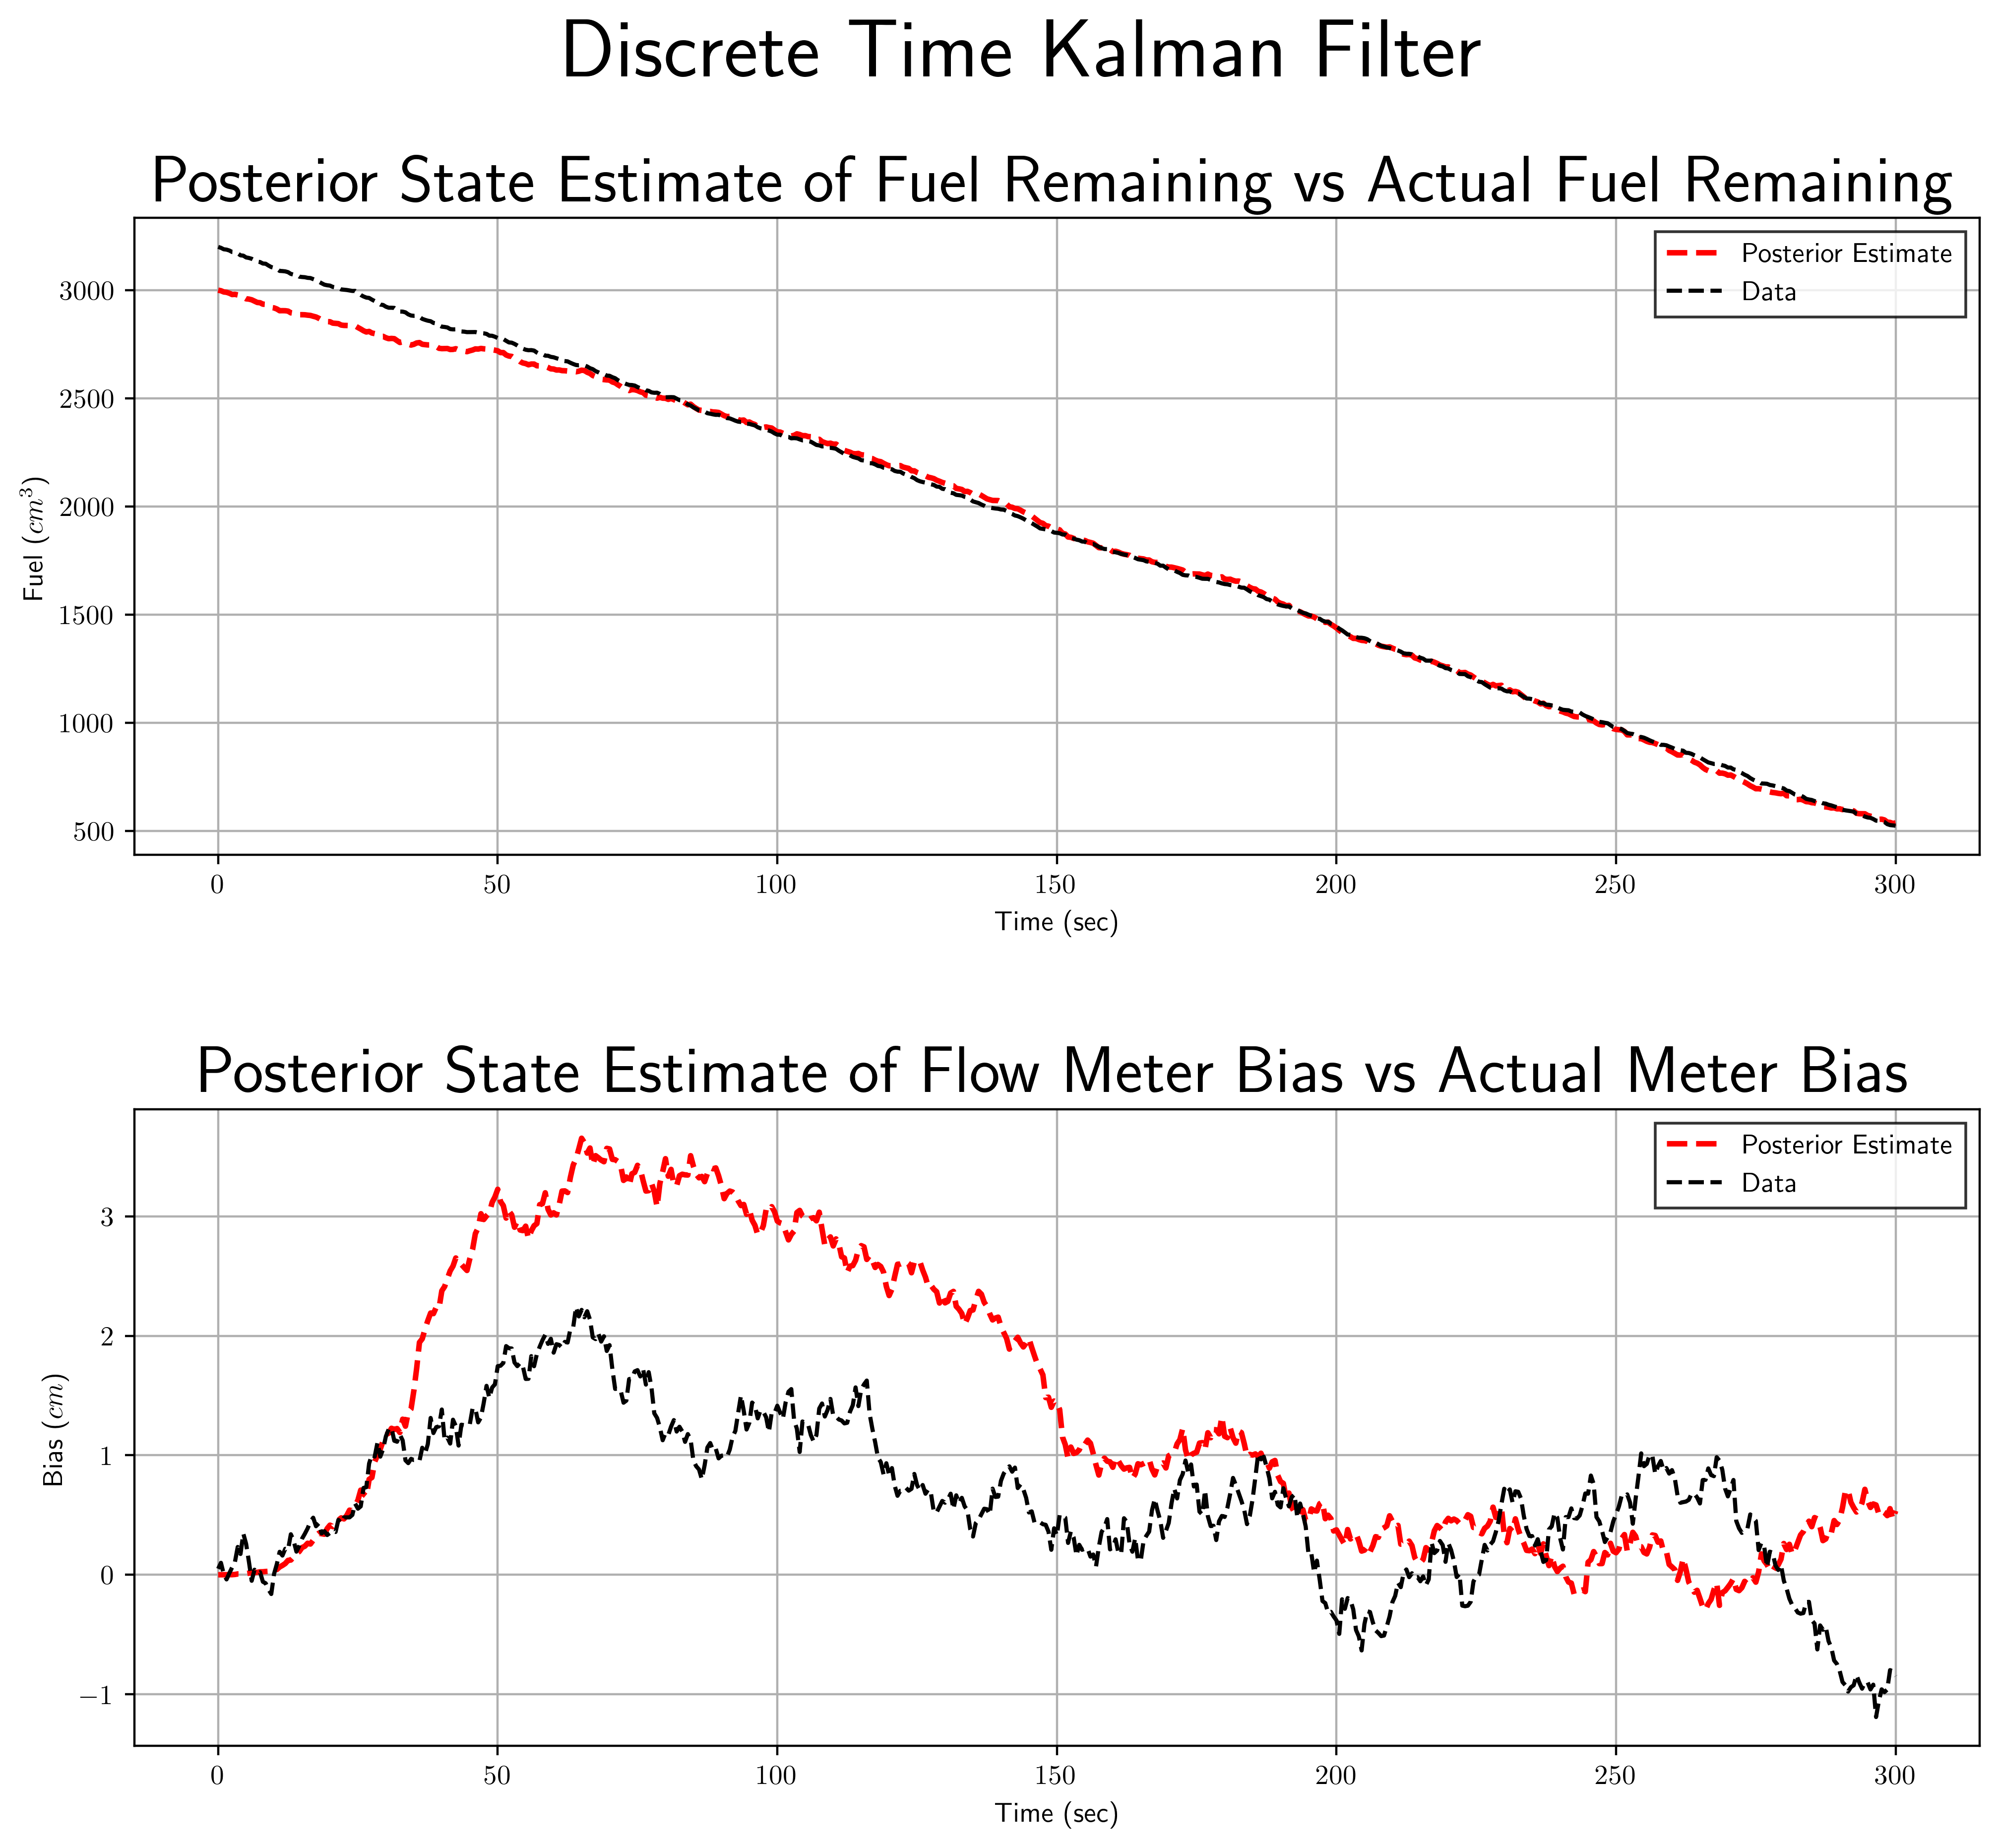

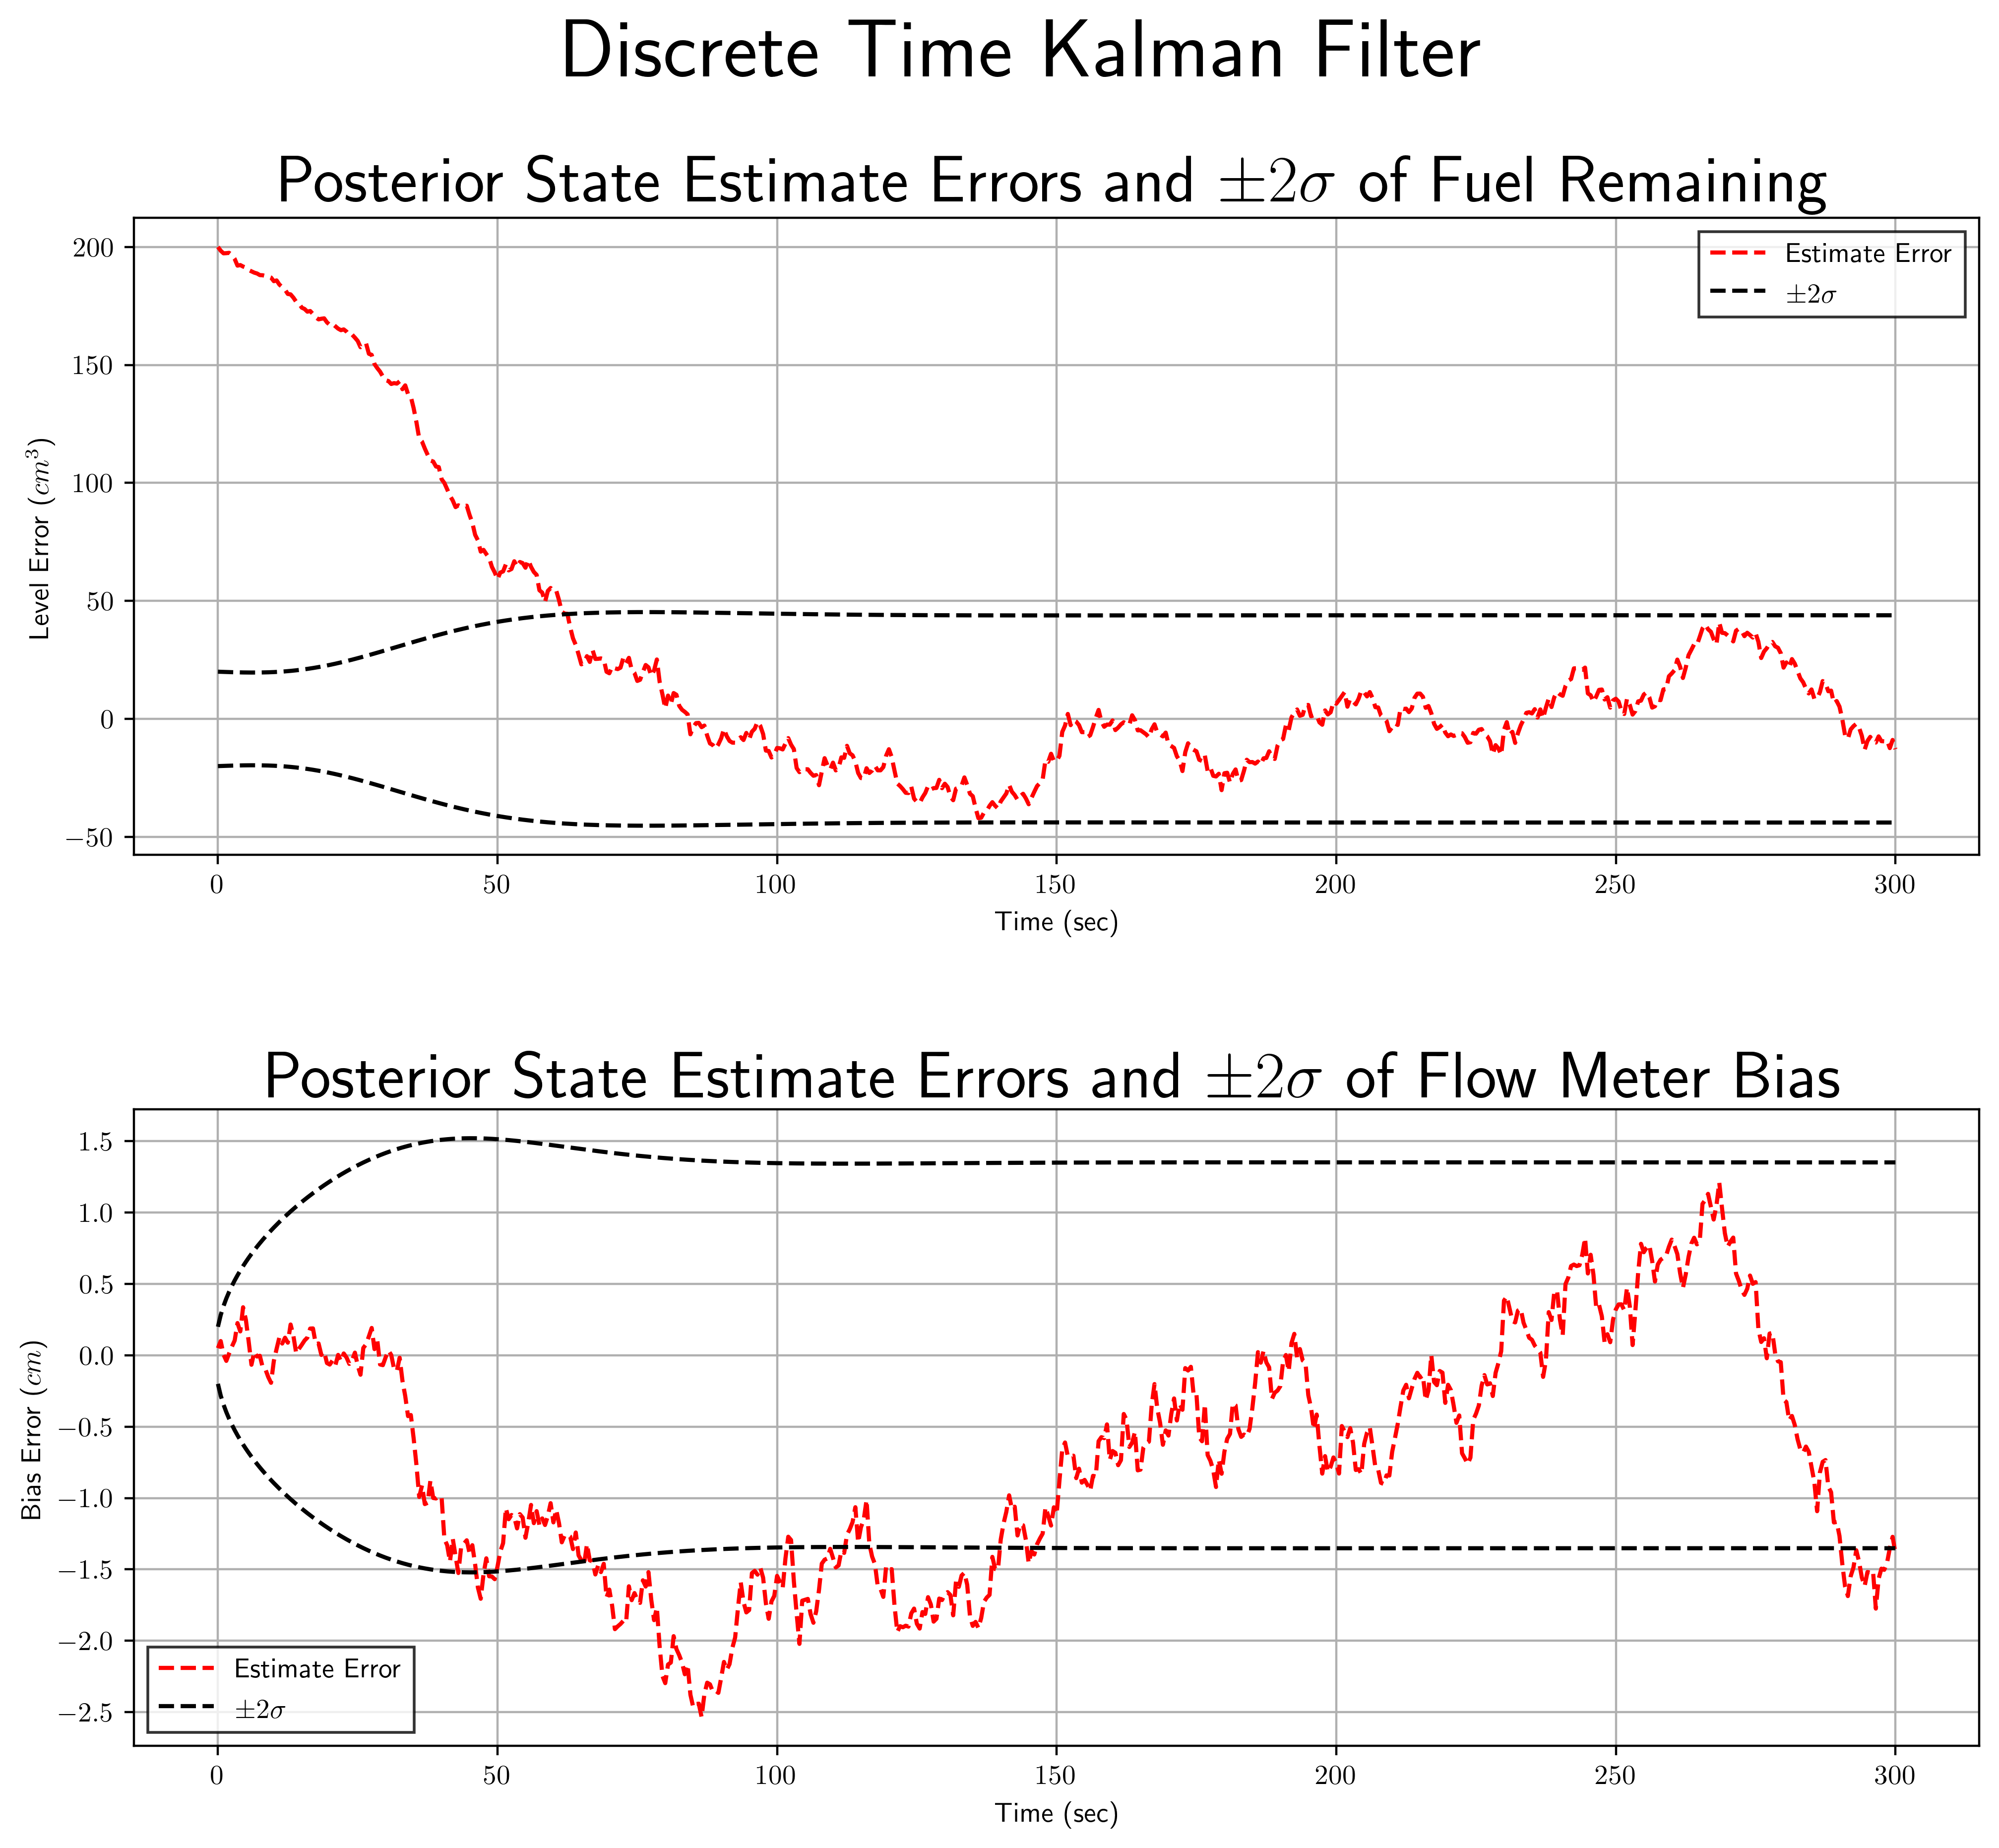

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=400)
fig.suptitle("Discrete Time Kalman Filter", fontsize=30)

ax1.set_title(
    "Posterior State Estimate of Fuel Remaining vs Actual Fuel Remaining", fontsize=24
)
ax1.plot(t, res[:, 0], "r--", lw=2, label="Posterior Estimate")
ax1.plot(t, df["f_k"], "k--", label="Data")
ax1.grid()
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Fuel ($cm^3$)")
leg = ax1.legend(fancybox=False)

ax2.set_title(
    "Posterior State Estimate of Flow Meter Bias vs Actual Meter Bias", fontsize=24
)
ax2.plot(t, res[:, 1], "r--", lw=2, label="Posterior Estimate")
ax2.plot(t, df["b_k"], "k--", label="Data")
ax2.grid()
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Bias ($cm$)")
ax2.legend(fancybox=False)
plt.subplots_adjust(hspace=0.4)
plt.savefig("2a.png")

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=400)
fig.suptitle("Discrete Time Kalman Filter", fontsize=30)

diffs = df[["f_k", "b_k"]].to_numpy() - res
ax1.set_title(
    "Posterior State Estimate Errors and $\pm 2\sigma$ of Fuel Remaining", fontsize=24
)
ax1.plot(t, diffs[:, 0], "r--", label="Estimate Error")
ax1.plot(t, 2 * np.sqrt(covs[0, 0, :]), "k--", label="$\pm 2\sigma$")
ax1.plot(t, -2 * np.sqrt(covs[0, 0, :]), "k--")
ax1.grid()
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Level Error ($cm^3$)")
ax1.legend(fancybox=False)


ax2.set_title(
    "Posterior State Estimate Errors and $\pm 2\sigma$ of Flow Meter Bias", fontsize=24
)
ax2.plot(t, diffs[:, 1], "r--", label="Estimate Error")
ax2.plot(t, 2 * np.sqrt(covs[1, 1, :]), "k--", label="$\pm 2\sigma$")
ax2.plot(t, -2 * np.sqrt(covs[1, 1, :]), "k--")
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Bias Error ($cm$)")
ax2.grid()
plt.subplots_adjust(hspace=0.4)
ax2.legend(fancybox=False)
plt.savefig("2b.png")

In [43]:
P_inf = solve_discrete_are(F.T, G.reshape(2, 1), Q, R)

## Part A - Steady State Kalman Filter

In [44]:
def predict_update(x, z, u, F, G, P, K, H):
    xhat_k_km1 = np.dot(F, x) + np.dot(G, u)
    yhat = z - np.dot(H, xhat_k_km1)
    x_out = xhat_k_km1 + np.dot(K, yhat)
    return x_out

In [45]:
res_a = np.zeros((n, 2))
P_inf = covs[:, :, -1]

K_inf = Ks[-1]
for k in range(n):
    if k == 0:
        x = x0
        res_a[k] = x
        continue
    u = df.loc[k - 1, "u_k"]
    z = df[["u_k", "y_k"]].to_numpy()[k][1]
    xu = predict_update(x, z, u, F, G, P_inf, K_inf, H)
    x = xu
    res_a[k] = x

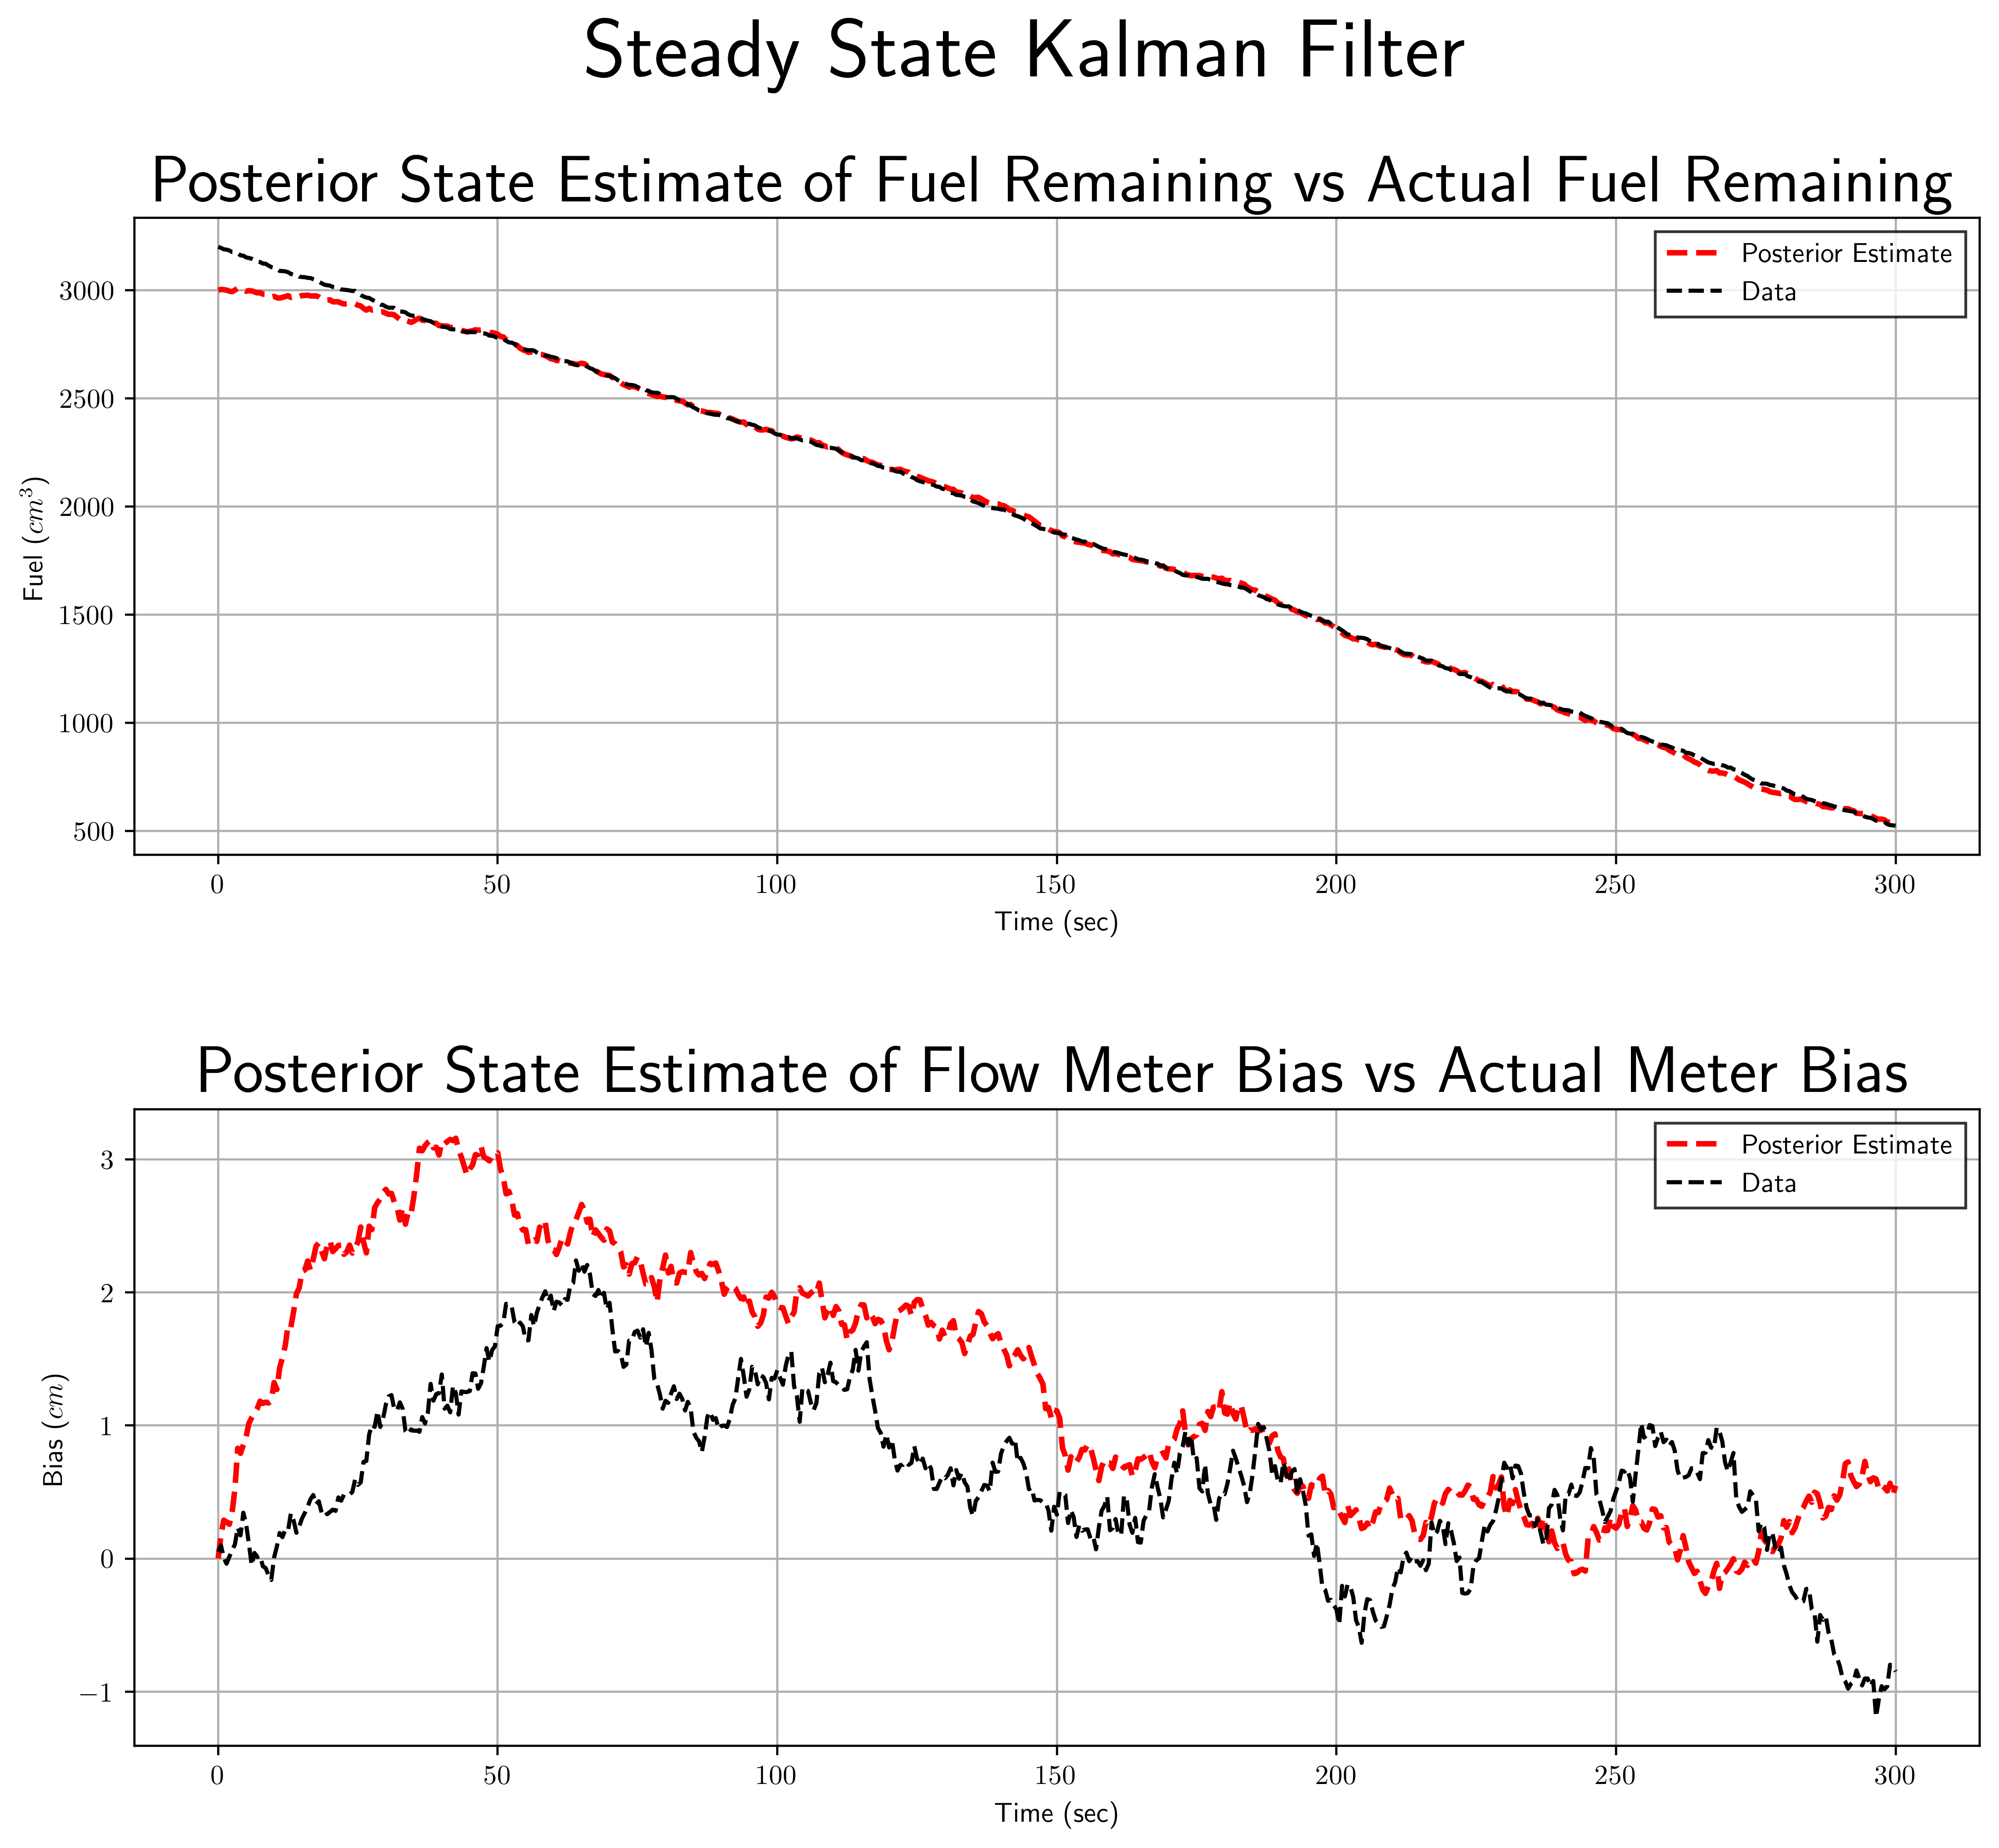

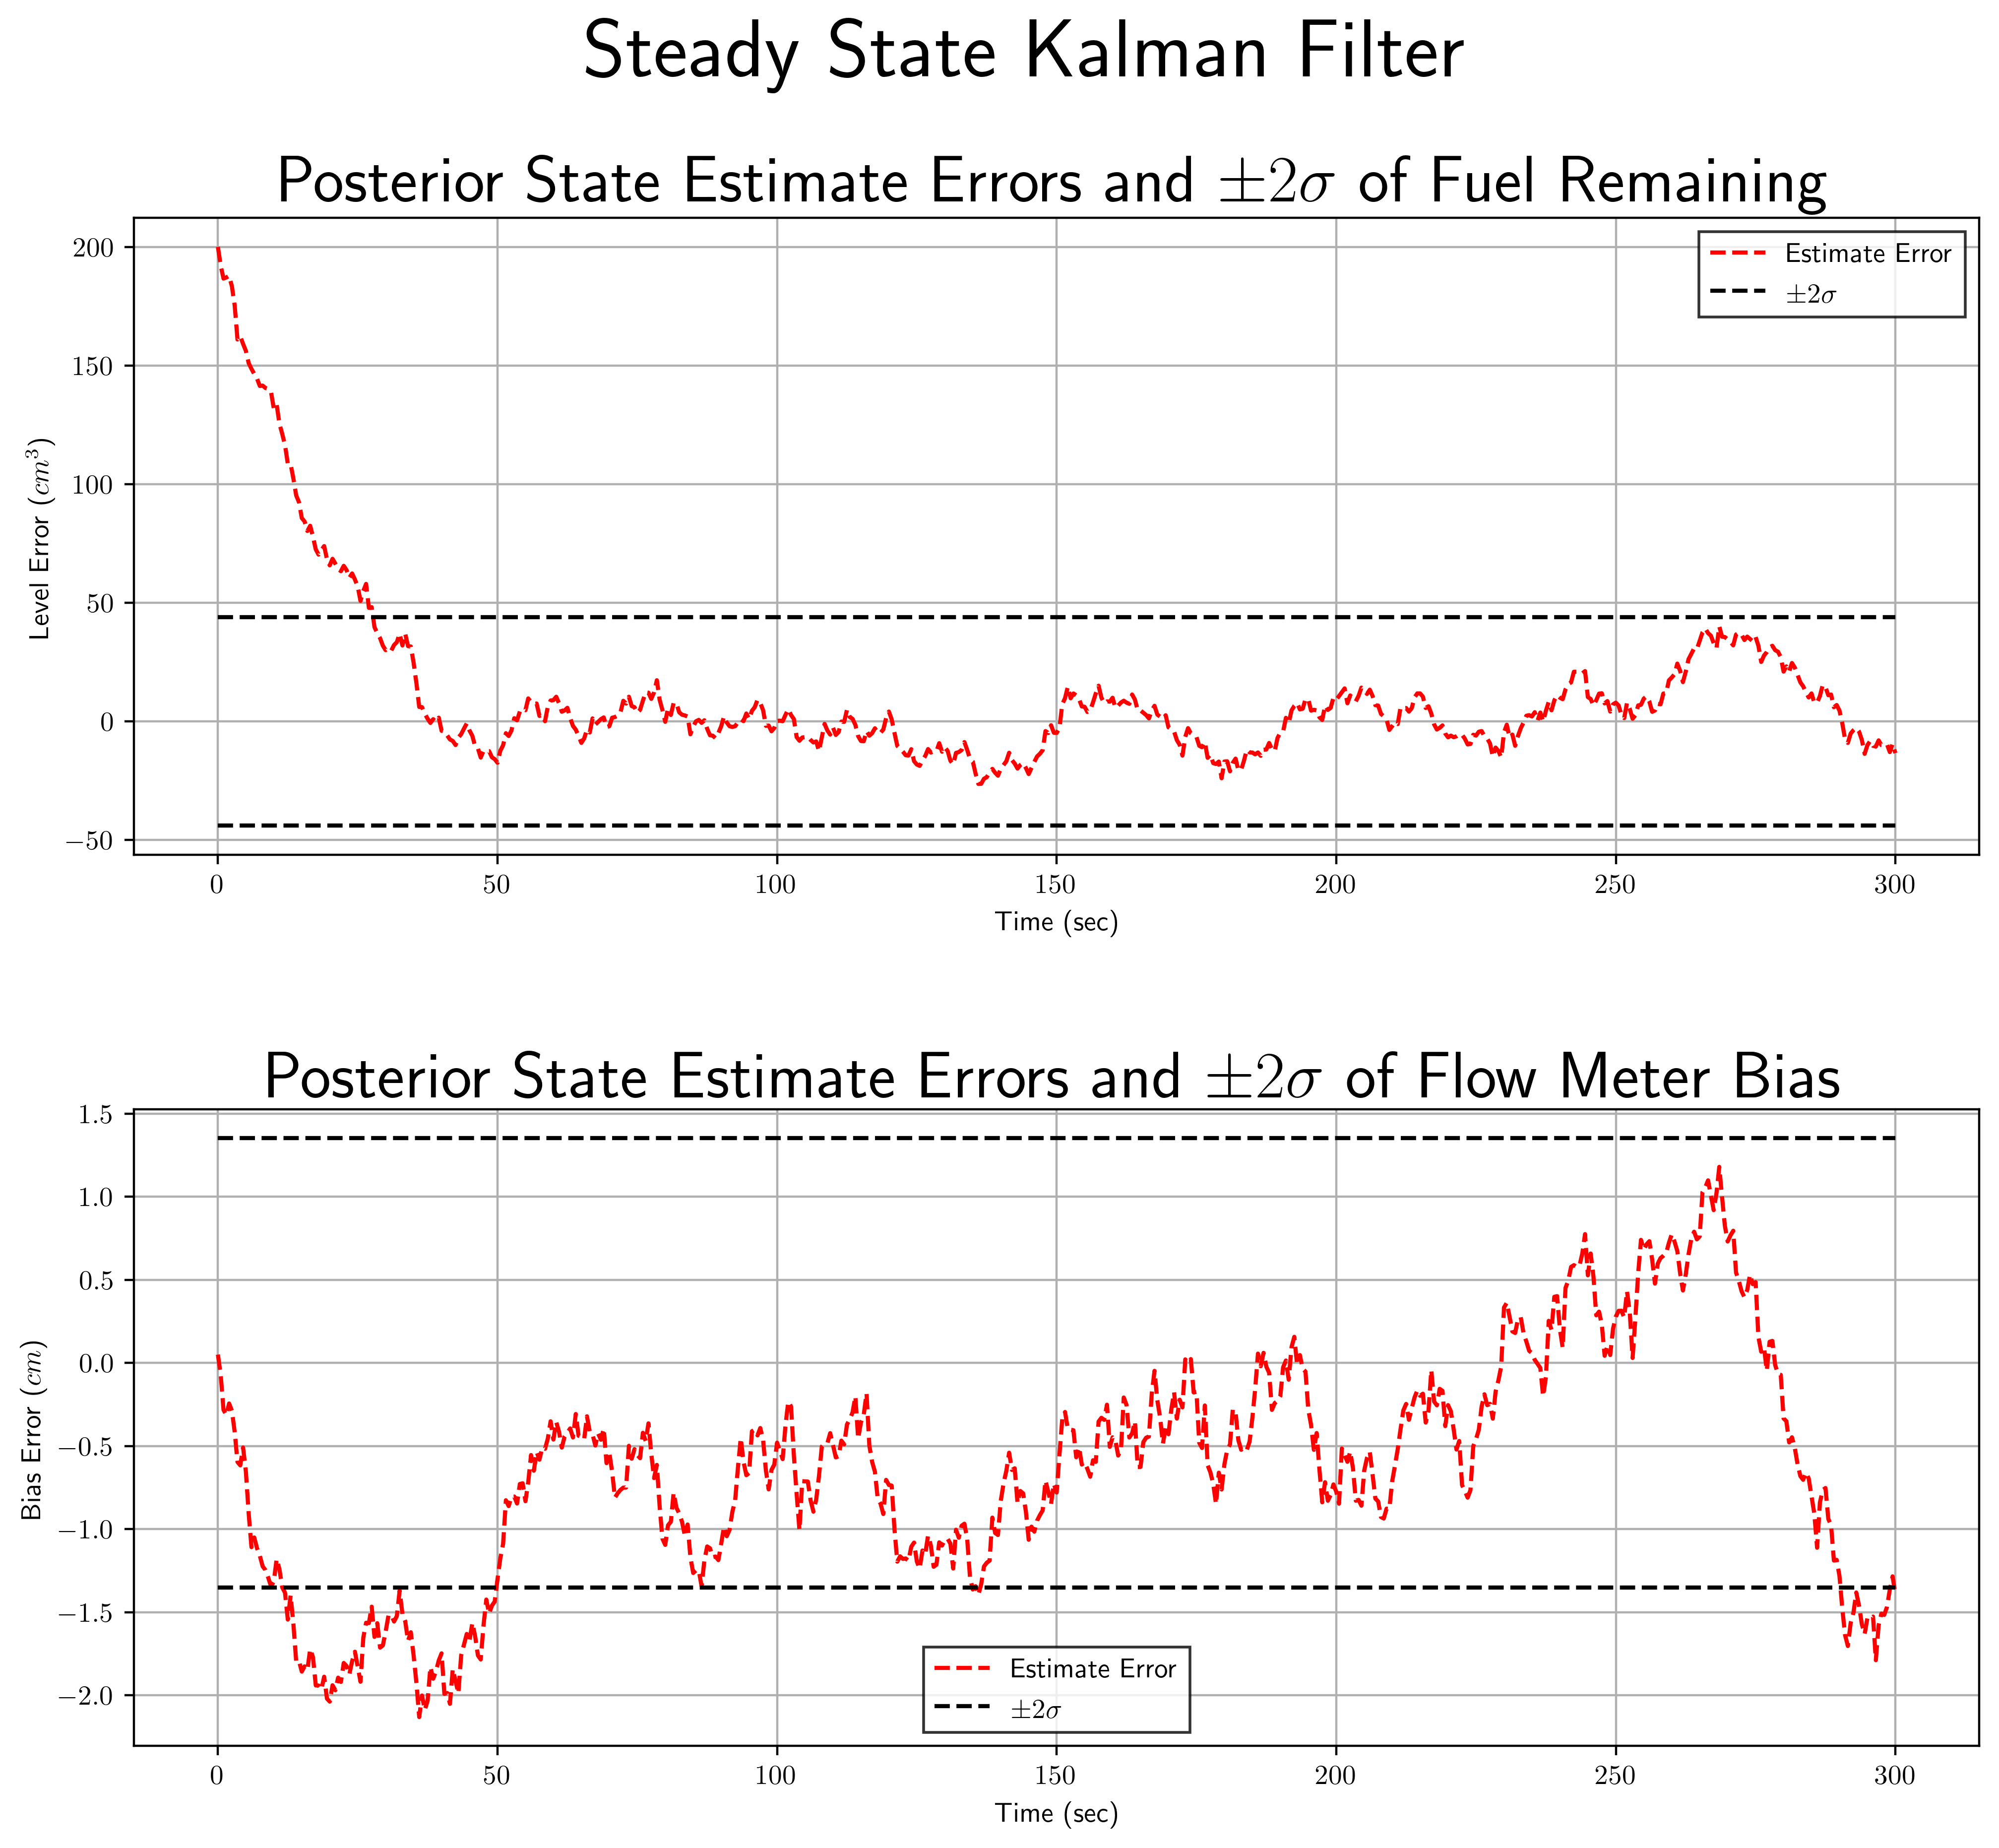

In [46]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=400)
fig.suptitle("Steady State Kalman Filter", fontsize=30)
ax1.set_title(
    "Posterior State Estimate of Fuel Remaining vs Actual Fuel Remaining", fontsize=24
)
ax1.plot(t, res_a[:, 0], "r--", lw=2, label="Posterior Estimate")
ax1.plot(t, df["f_k"], "k--", label="Data")
ax1.grid()
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Fuel ($cm^3$)")
leg = ax1.legend(fancybox=False)

ax2.set_title(
    "Posterior State Estimate of Flow Meter Bias vs Actual Meter Bias", fontsize=24
)
ax2.plot(t, res_a[:, 1], "r--", lw=2, label="Posterior Estimate")
ax2.plot(t, df["b_k"], "k--", label="Data")
ax2.grid()
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Bias ($cm$)")
ax2.legend(fancybox=False)
plt.subplots_adjust(hspace=0.4)
plt.savefig("1a.png")


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=400)
fig.suptitle("Steady State Kalman Filter", fontsize=30)
diffs = df[["f_k", "b_k"]].to_numpy() - res_a
ax1.set_title(
    "Posterior State Estimate Errors and $\pm 2\sigma$ of Fuel Remaining", fontsize=24
)
ax1.plot(t, diffs[:, 0], "r--", label="Estimate Error")
ax1.plot(t, np.repeat(2 * np.sqrt(P_inf[0, 0]), 601), "k--", label="$\pm 2\sigma$")
ax1.plot(t, np.repeat(-2 * np.sqrt(P_inf[0, 0]), 601), "k--")
ax1.grid()
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Level Error ($cm^3$)")
ax1.legend(fancybox=False)


ax2.set_title(
    "Posterior State Estimate Errors and $\pm 2\sigma$ of Flow Meter Bias", fontsize=24
)
ax2.plot(t, diffs[:, 1], "r--", label="Estimate Error")
ax2.plot(t, np.repeat(2 * np.sqrt(P_inf[1, 1]), 601), "k--", label="$\pm 2\sigma$")
ax2.plot(t, np.repeat(-2 * np.sqrt(P_inf[1, 1]), 601), "k--")
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Bias Error ($cm$)")
ax2.grid()
plt.subplots_adjust(hspace=0.4)
ax2.legend(fancybox=False)
plt.savefig("1b.png")

## Part C - Discrete-Time Covariance Intersection Kalman Filter (CI-KF)

In [47]:
def predict(u, x, P, F, G, Q):
    xhat_k_km1 = np.dot(F, x) + np.dot(G, u)
    Phat_k_km1 = F @ P @ F.T + Q
    return xhat_k_km1, Phat_k_km1


def update_CI(z, x, P, H, R, omega):
    x_in = x
    z_in = z
    P_in = P

    yhat = z_in - np.dot(H, x_in)
    P_out = np.linalg.inv(
        omega * np.linalg.inv(P_in) + (1 - omega) * np.dot(np.dot(H.T, 1 / R), H)
    )
    K = (1 - omega) * np.dot(np.dot(P_out, H.T), 1 / R)
    x_out = x_in + np.dot(K, yhat)
    return x_out, P_out, K

In [48]:
res_c = np.zeros((n, 2))  # array to hold posterior state estimates
covs_c = np.zeros((2, 2, n))  # array to hold posterior P_k estimates
ws = np.arange(0.01, 1.01, 0.01)
for k in range(n):
    if k == 0:
        x = x0
        P = P0
        res_c[k] = x
        covs_c[:, :, k] = P
        continue
    u = df.loc[k - 1, "u_k"]
    z = df[["u_k", "y_k"]].to_numpy()[k][1]
    xp, Pp = predict(u, x, P, F, G, Q)

    # Search for w that minimizes trace of P
    traces_P = np.zeros((len(ws), 1))
    for j, w in enumerate(ws):
        xu, Pu, K = update_CI(z, xp, Pp, H, R, omega=w)
        traces_P[j] = np.trace(Pu)
    w_opt = ws[np.argmin(traces_P)]
    if w_opt > 0.95:
        w_opt = 0.5
    xu, Pu, K = update_CI(z, xp, Pp, H, R, omega=w_opt)
    P = Pu
    x = xu
    res_c[k] = x
    covs_c[:, :, k] = P

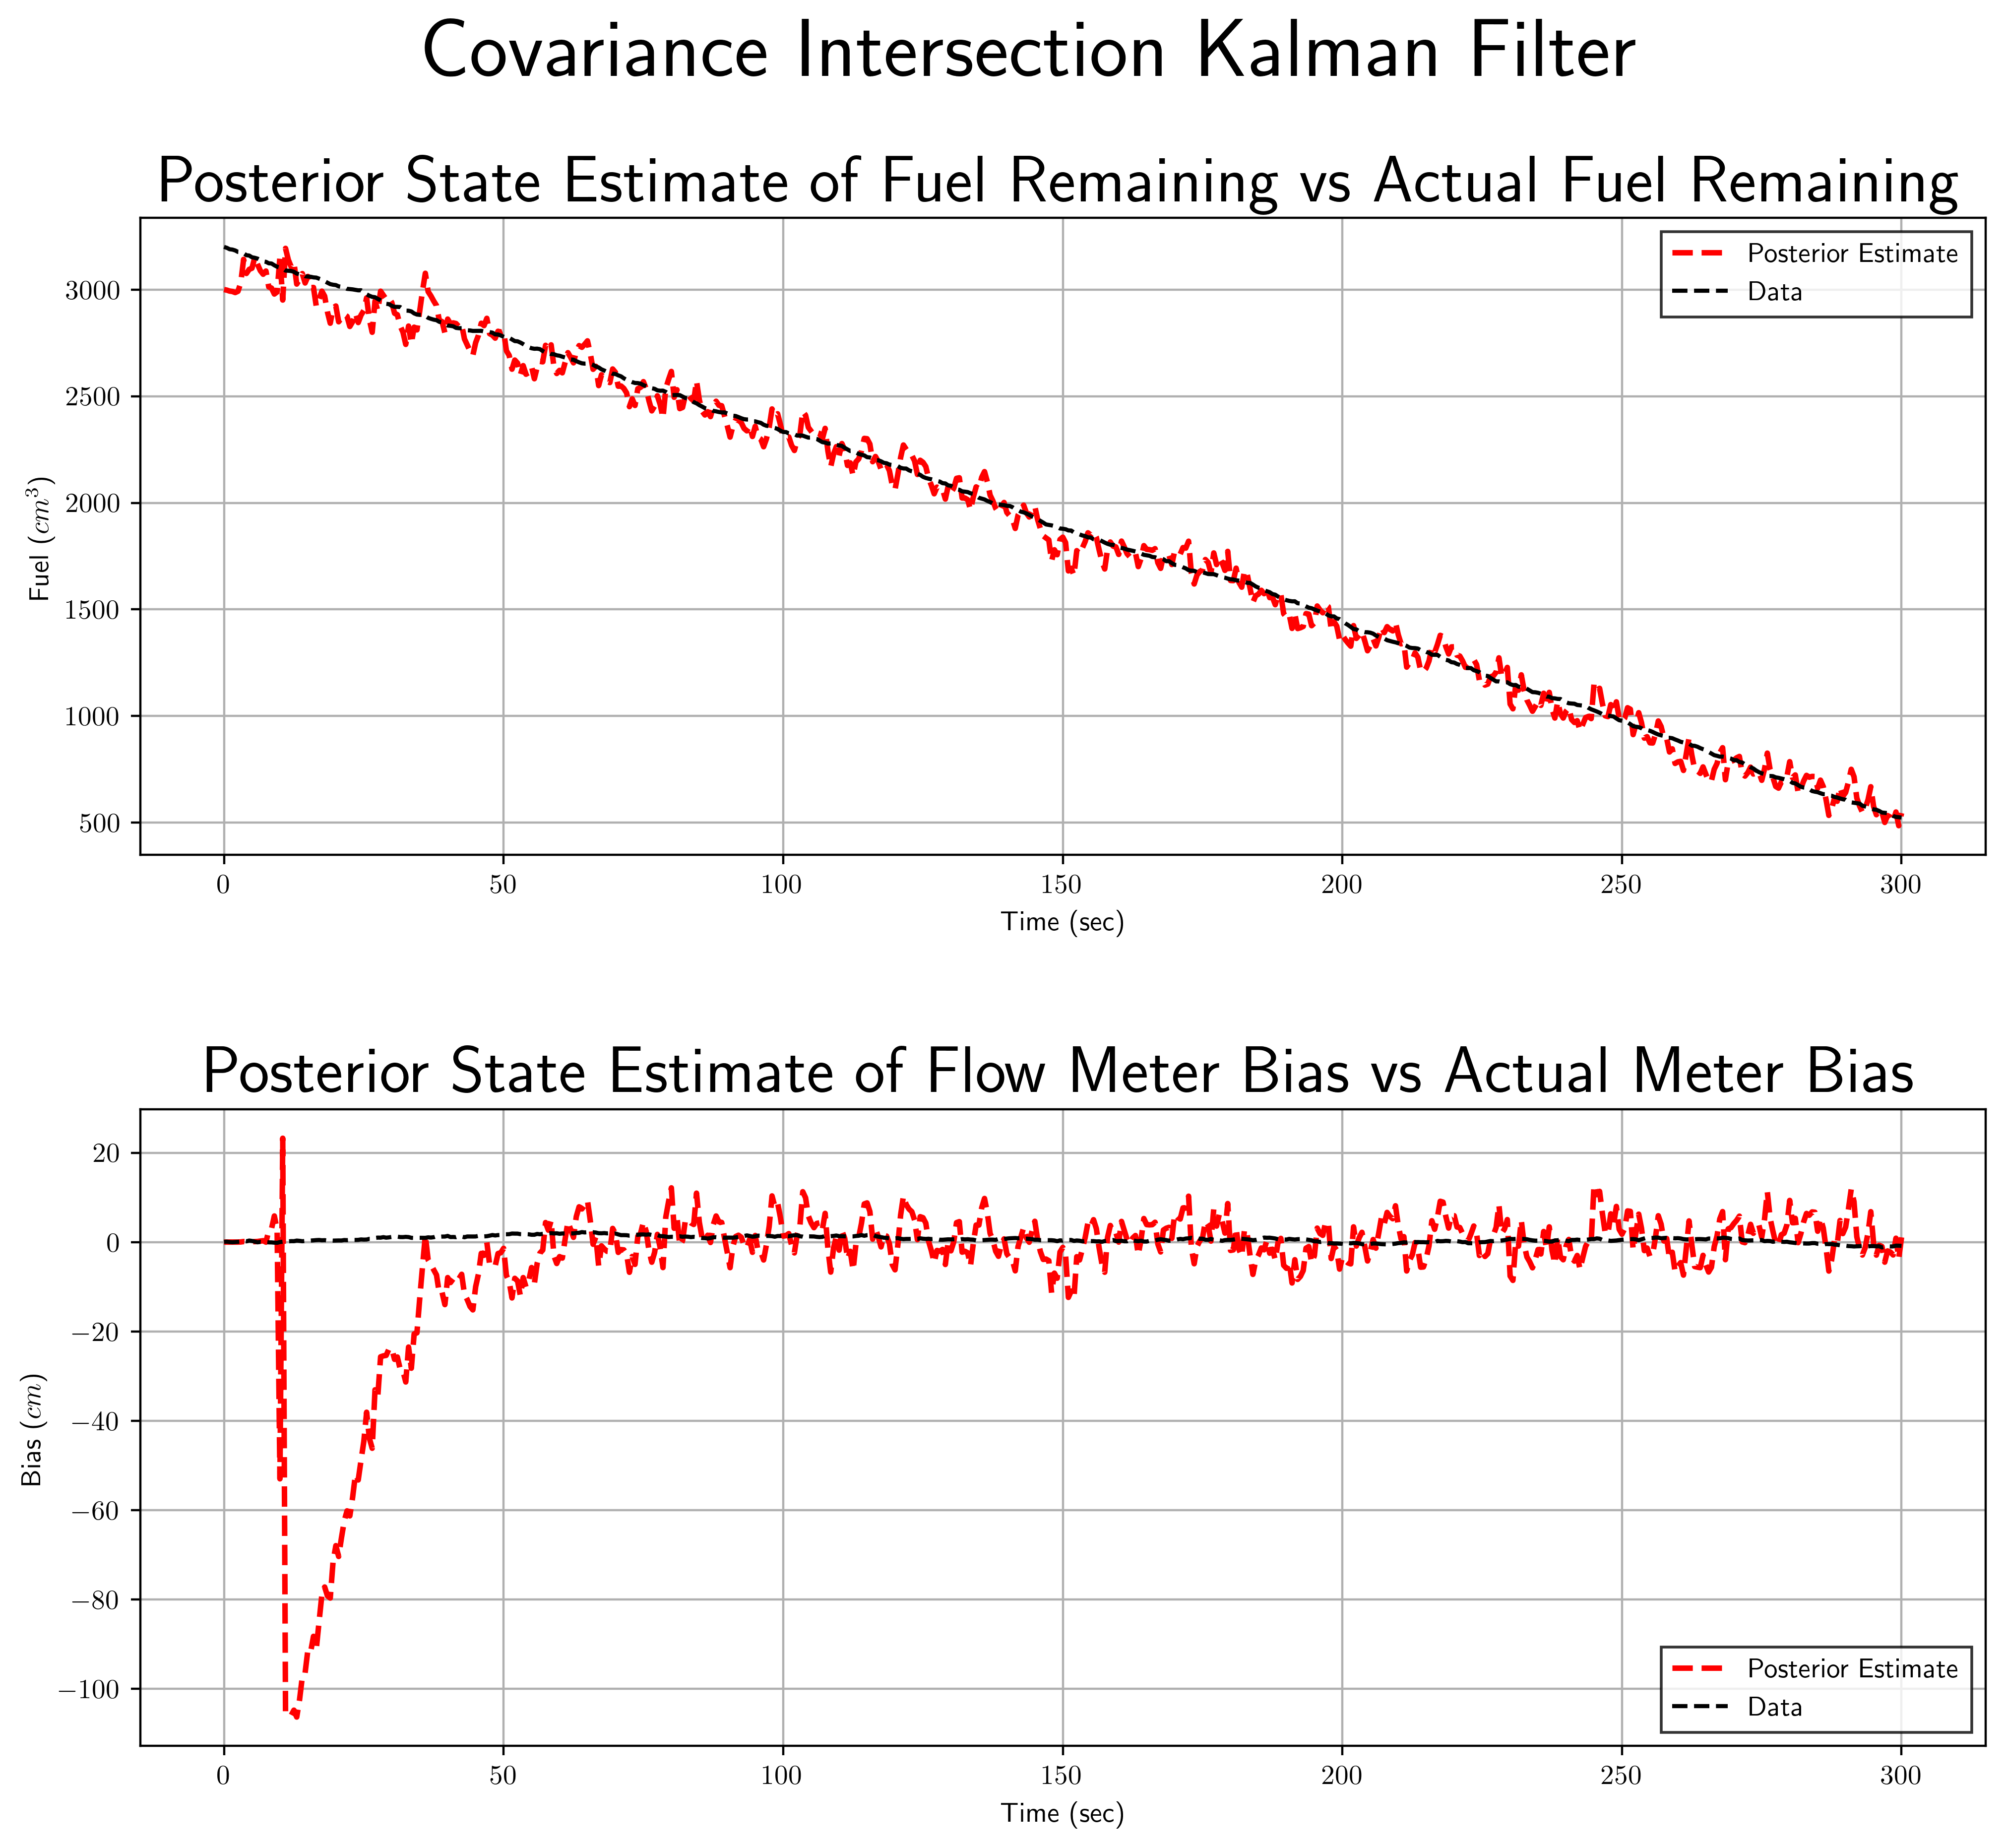

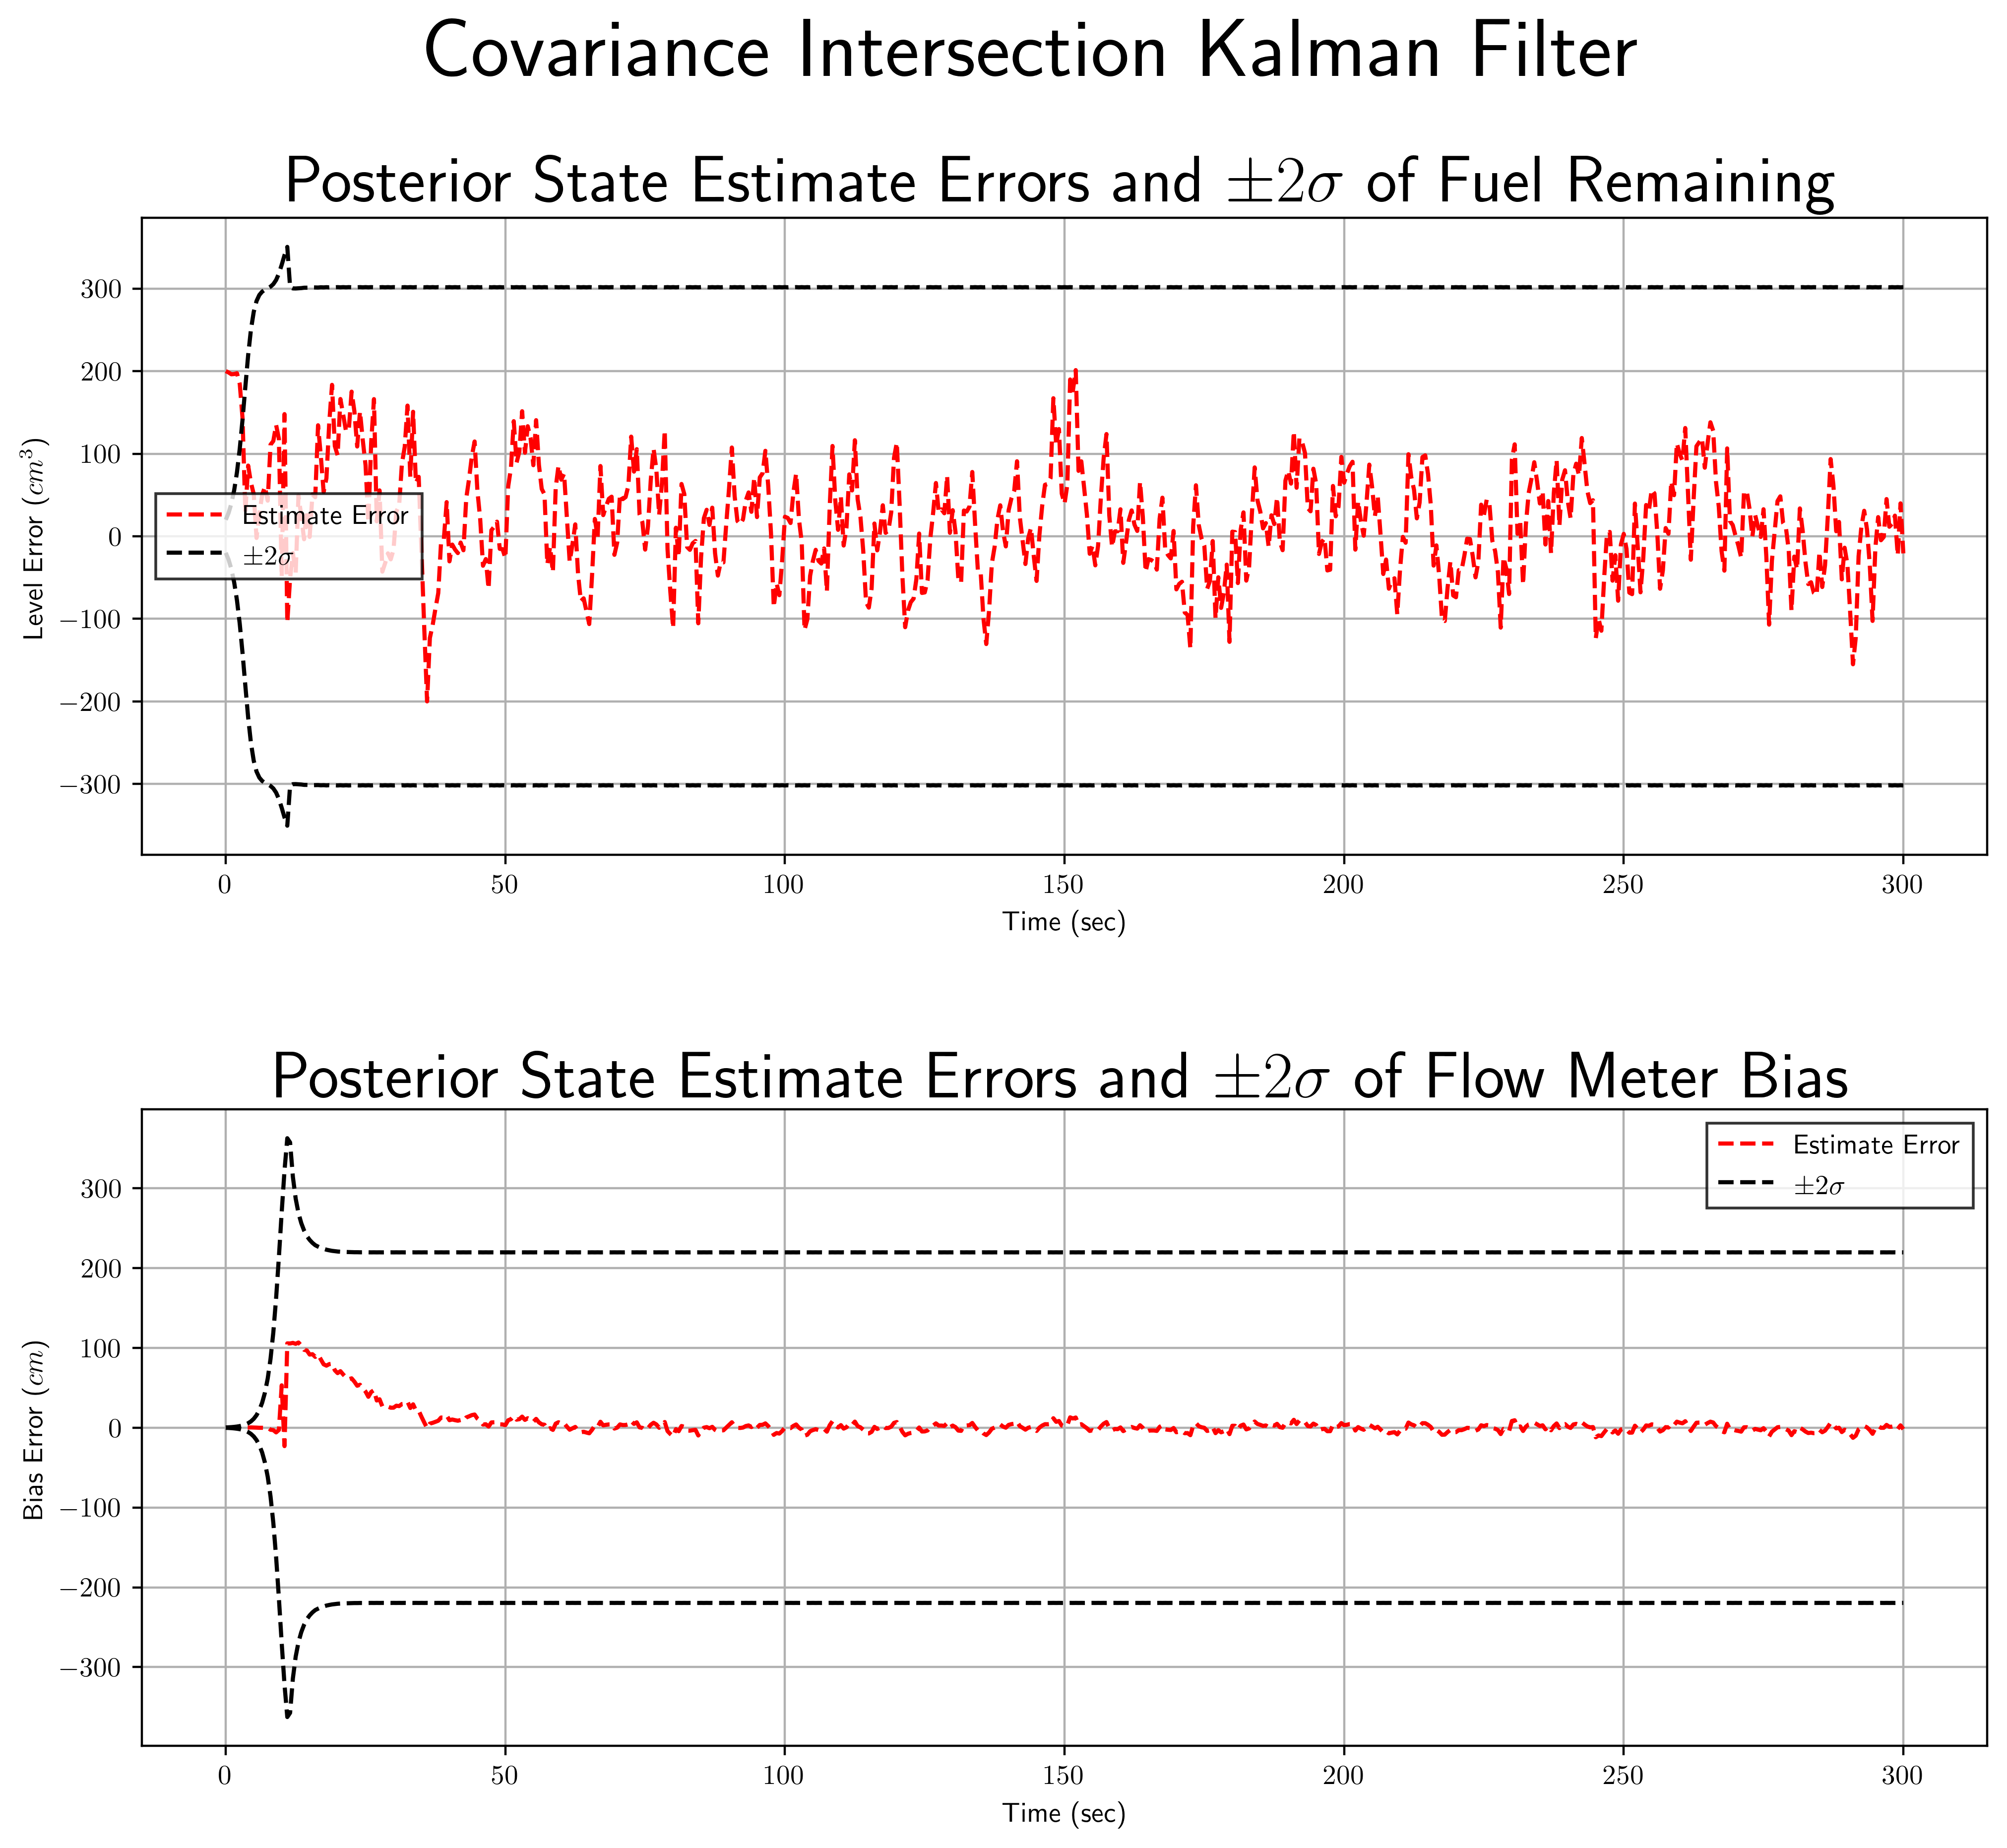

In [49]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=400)
fig.suptitle("Covariance Intersection Kalman Filter", fontsize=30)
ax1.set_title(
    "Posterior State Estimate of Fuel Remaining vs Actual Fuel Remaining", fontsize=24
)
ax1.plot(t, res_c[:, 0], "r--", lw=2, label="Posterior Estimate")
ax1.plot(t, df["f_k"], "k--", label="Data")
ax1.grid()
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Fuel ($cm^3$)")
leg = ax1.legend(fancybox=False)

ax2.set_title(
    "Posterior State Estimate of Flow Meter Bias vs Actual Meter Bias", fontsize=24
)
ax2.plot(t, res_c[:, 1], "r--", lw=2, label="Posterior Estimate")
ax2.plot(t, df["b_k"], "k--", label="Data")
ax2.grid()
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Bias ($cm$)")
ax2.legend(fancybox=False)
plt.subplots_adjust(hspace=0.4)
plt.savefig("3a.png")

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=400)
fig.suptitle("Covariance Intersection Kalman Filter", fontsize=30)
diffs = df[["f_k", "b_k"]].to_numpy() - res_c
ax1.set_title(
    "Posterior State Estimate Errors and $\pm 2\sigma$ of Fuel Remaining", fontsize=24
)
ax1.plot(t, diffs[:, 0], "r--", label="Estimate Error")
ax1.plot(t, 2 * np.sqrt(covs_c[0, 0, :]), "k--", label="$\pm 2\sigma$")
ax1.plot(
    t,
    -2
    * np.sqrt(
        covs_c[
            0,
            0,
        ]
    ),
    "k--",
)
ax1.grid()
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Level Error ($cm^3$)")
ax1.legend(fancybox=False)


ax2.set_title(
    "Posterior State Estimate Errors and $\pm 2\sigma$ of Flow Meter Bias", fontsize=24
)
ax2.plot(t, diffs[:, 1], "r--", label="Estimate Error")
ax2.plot(t, 2 * np.sqrt(covs_c[1, 1, :]), "k--", label="$\pm 2\sigma$")
ax2.plot(t, -2 * np.sqrt(covs_c[1, 1, :]), "k--")
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Bias Error ($cm$)")
ax2.grid()
plt.subplots_adjust(hspace=0.4)
ax2.legend(fancybox=False)
plt.savefig("3b.png")

## Part D - Discrete-Time Kalman Smoother Using Discrete Time KF 

Rauch–Tung–Striebel algorithm taken from https://users.aalto.fi/~ssarkka/course_k2011/pdf/handout7.pdf

In [50]:
Ps = covs
Xs = res
x, P, Pp = Xs.copy(), Ps.copy(), Ps.copy()
K = np.zeros((n, 2, 2))
for k in range(n - 2, -1, -1):
    Pp[:, :, k] = F @ P[:, :, k] @ F.T + Q
    K[k] = P[:, :, k] @ F.T @ np.linalg.inv(Pp[:, :, k])
    x[k] += K[k] @ (x[k + 1] - (F @ x[k]))
    P[:, :, k] += K[k] @ (P[:, :, k + 1] - Pp[:, :, k]) @ K[k].T

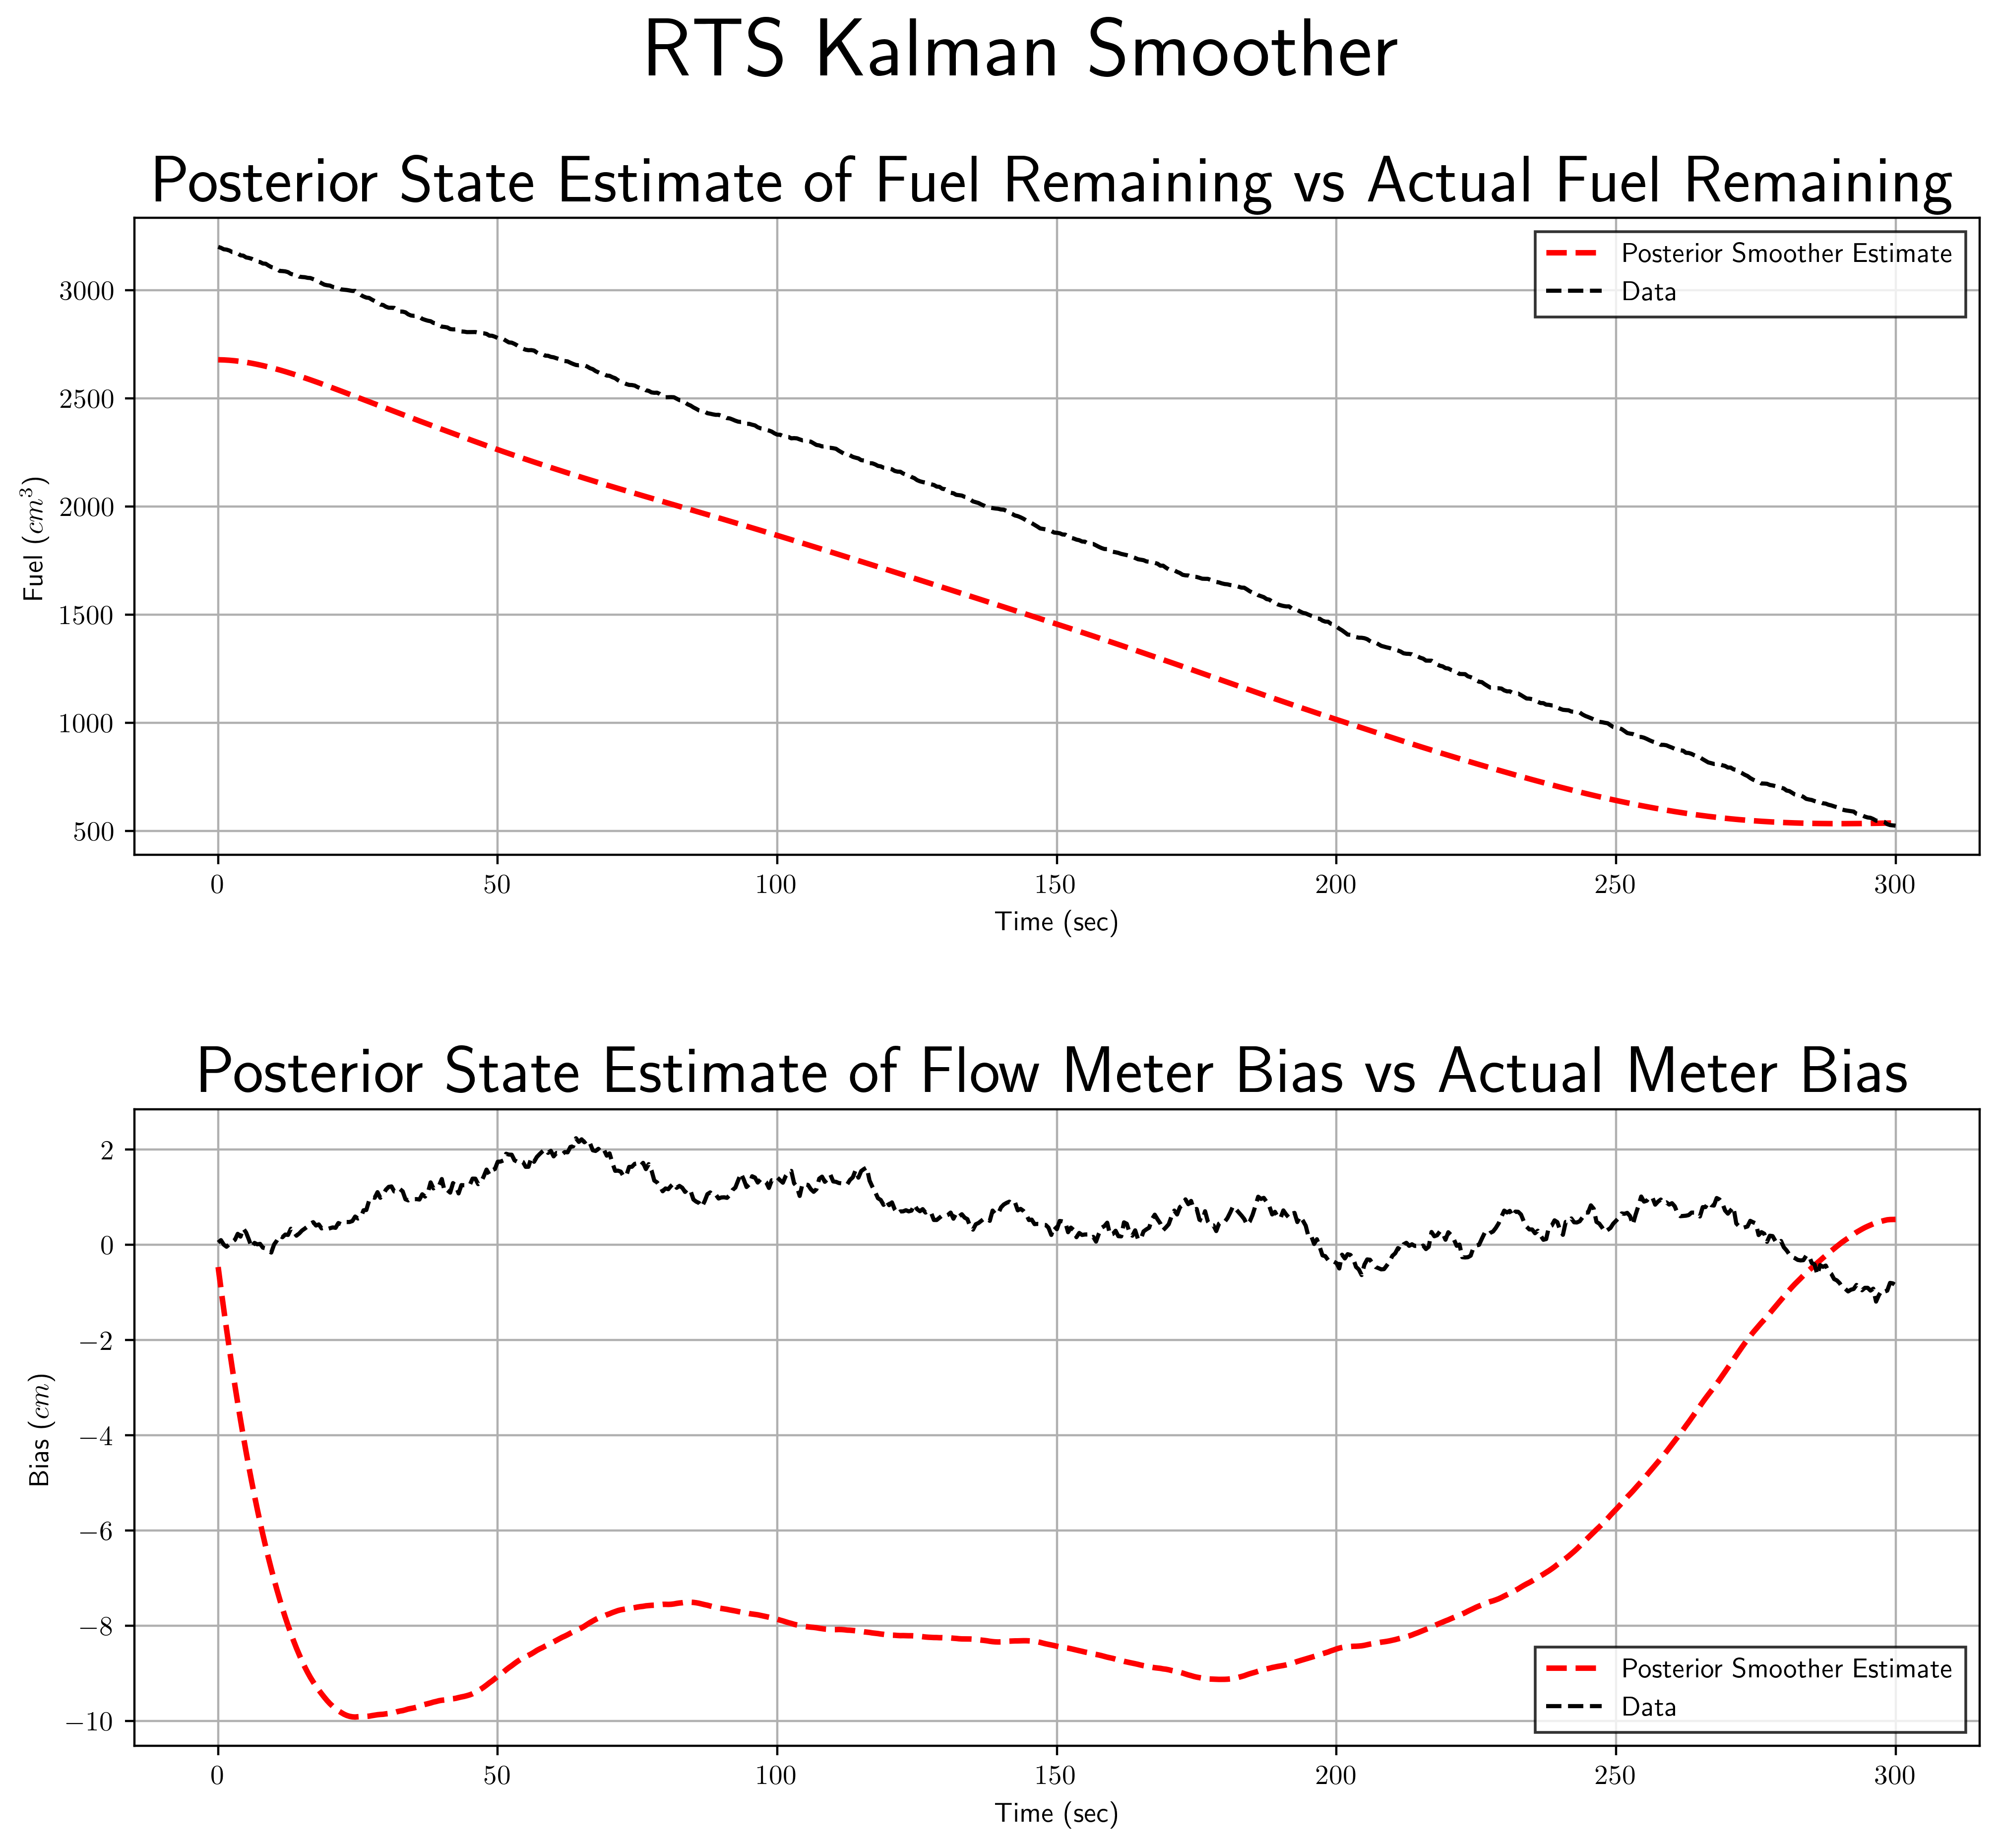

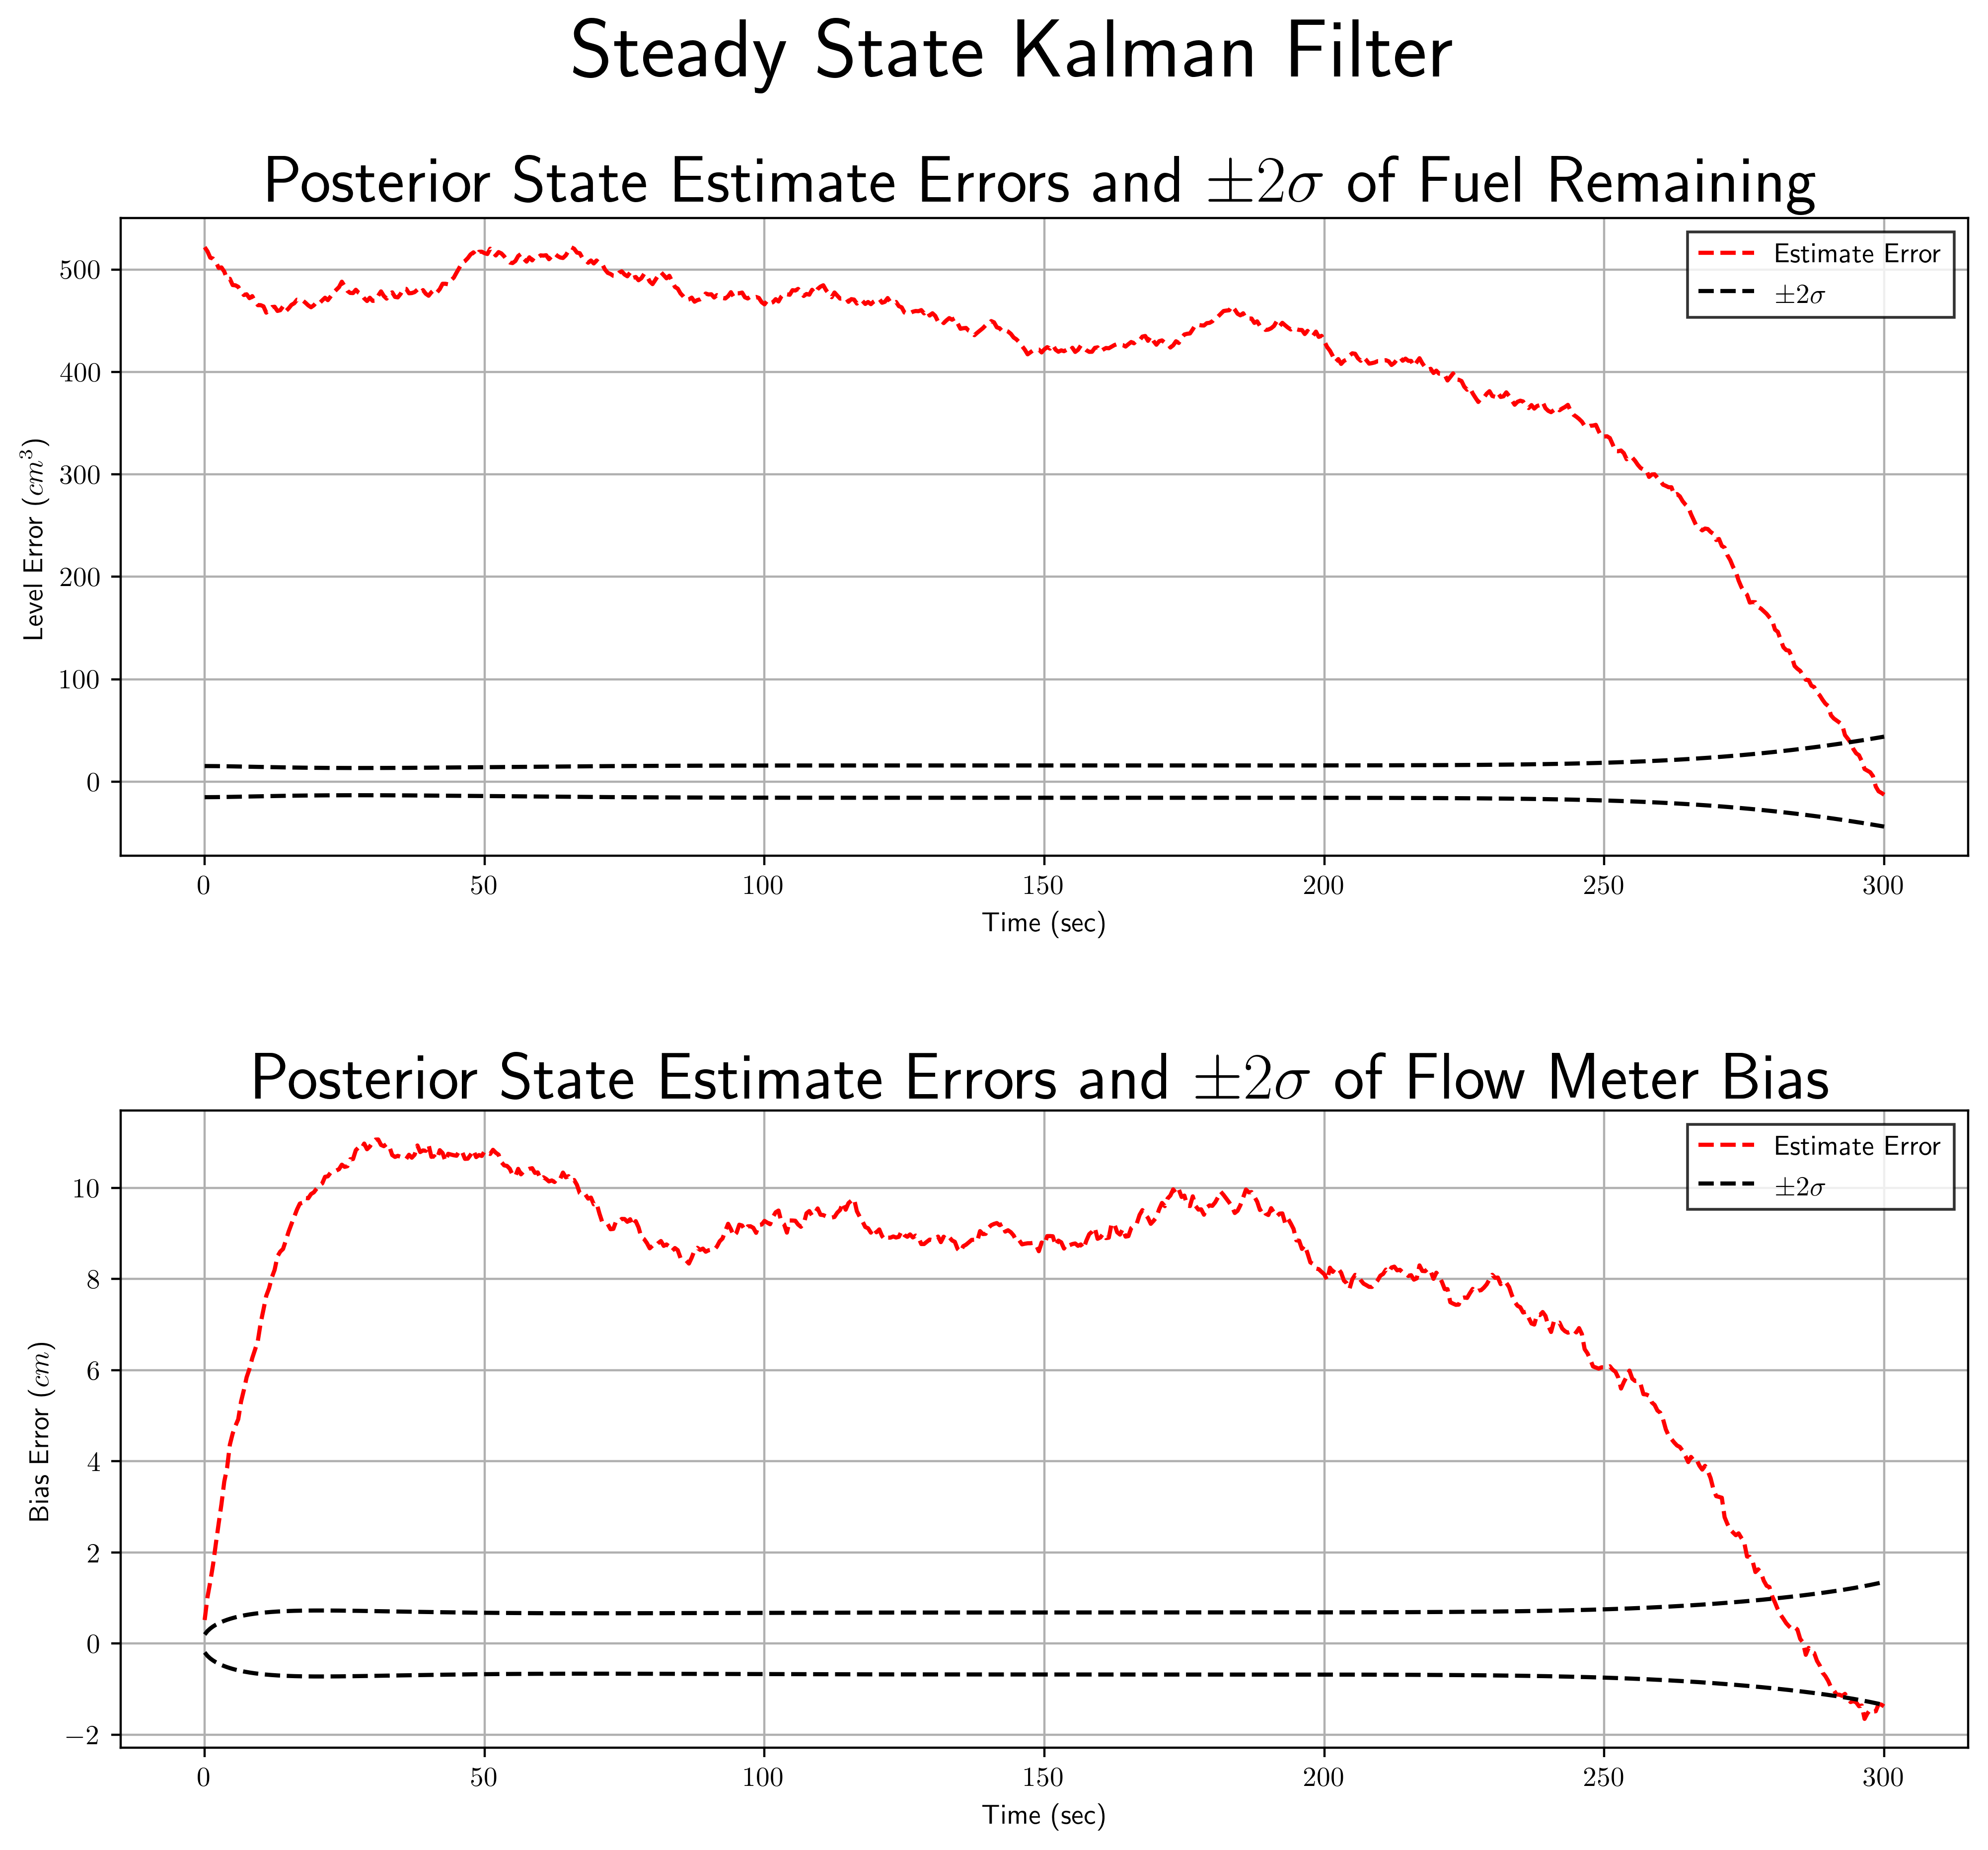

In [51]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=400)
fig.suptitle("RTS Kalman Smoother", fontsize=30)
ax1.set_title(
    "Posterior State Estimate of Fuel Remaining vs Actual Fuel Remaining", fontsize=24
)
ax1.plot(t, x[:, 0], "r--", lw=2, label="Posterior Smoother Estimate")
ax1.plot(t, df["f_k"], "k--", label="Data")
ax1.grid()
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Fuel ($cm^3$)")
leg = ax1.legend(fancybox=False)

ax2.set_title(
    "Posterior State Estimate of Flow Meter Bias vs Actual Meter Bias", fontsize=24
)
ax2.plot(t, x[:, 1], "r--", lw=2, label="Posterior Smoother Estimate")
ax2.plot(t, df["b_k"], "k--", label="Data")
ax2.grid()
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Bias ($cm$)")
ax2.legend(fancybox=False)
plt.subplots_adjust(hspace=0.4)
plt.savefig("4a.png")


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=400)
fig.suptitle("Steady State Kalman Filter", fontsize=30)
diffs = df[["f_k", "b_k"]].to_numpy() - x
ax1.set_title(
    "Posterior State Estimate Errors and $\pm 2\sigma$ of Fuel Remaining", fontsize=24
)
ax1.plot(t, diffs[:, 0], "r--", label="Estimate Error")
ax1.plot(t, 2 * np.sqrt(P[0, 0, :]), "k--", label="$\pm 2\sigma$")
ax1.plot(t, -2 * np.sqrt(P[0, 0, :]), "k--")
ax1.grid()
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Level Error ($cm^3$)")
ax1.legend(fancybox=False)


ax2.set_title(
    "Posterior State Estimate Errors and $\pm 2\sigma$ of Flow Meter Bias", fontsize=24
)
ax2.plot(t, diffs[:, 1], "r--", label="Estimate Error")
ax2.plot(t, 2 * np.sqrt(P[1, 1, :]), "k--", label="$\pm 2\sigma$")
ax2.plot(t, -2 * np.sqrt(P[1, 1, :]), "k--")
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Bias Error ($cm$)")
ax2.grid()
plt.subplots_adjust(hspace=0.4)
ax2.legend(fancybox=False)
plt.savefig("4b.png")

## Part E - Comment on the similarities and differences between the different state estimators and variances

> **Similarities**: 
> - The filters are all initialized with a lower variance/covariance than the value they converge to upon running. Initially, I thought this was an erraneous result, so I experimented with different values of $P_0$ and saw that this was a consistent behavior and that the filters were converging. 
> - Each filter did a significantly better job at estimating the fuel remaining than estimating the flow meter bias. Intuitively, I attribute this to the filters having access to a more 'fuel level-esque' meausurement, i.e., the tank level sensor data, wheras the flow meter bias doesn't have an analogous measurement so the filter has to rely more heavily on its model of the bias. This is reflected in the lower Kalman gain for the flow meter bias channel. 

> **Differences**: 
> - The covariance intersection filter performed significantly worse than the discrete time and steady state Kalman filters both in estimating the true state and the $2\sigma$  covariance bounds. This is consistent with the literature, because we are additonally trying to weigh the unknown covariances in the model vs the measurements.  
> - The steady state Kalman filter converged faster than any of the other Kalman filters. This is because the optimal Kalman gain is a constant for an LTI system and was pulled from the discrete-time case. I.e., the optimal Kalman gain was alerady calculated so it makes sense the filter converged quickly.
> - The Kalman smoother did not provide a reasonable estimate for either state. The errors are large and don't match up with the results I'd expect, so I assume this is a problem with my algorithm. 